In [17]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Fonction pour lire les données de transcription
def read_transcription(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Fonction pour lire les données du graphe de discours
def read_discourse_graph(file_path):
    with open(file_path, 'r') as file:
        data = [line.strip().split() for line in file]

    # Convertir les valeurs non numériques en indices numériques
    data = [(int(start), relation, int(end)) if start.isdigit() and end.isdigit() else (start, relation, end) for start, relation, end in data]

    return data

def create_dataframe(dialogue_id, transcription, discourse_graph, relation_dict, speaker_dict):
    rows = []

      # Iterate through all edges in the discourse graph
    for edge in discourse_graph:
        index_start, relation_type, index_end = edge

        # Retrieve speaker information
        speaker = transcription[index_start]['speaker']

        # Convert relation type to integer using the dictionary
        speaker_id = speaker_dict.get(speaker, -1)

        # Retrieve the sentence
        text = transcription[index_start]['text']

        # Convert relation type to integer using the dictionary
        relation_type_id = relation_dict.get(relation_type, -1)

        # Add a row to the DataFrame
        rows.append({
            'dialogue_id': dialogue_id,
            'index_start': index_start,
            'text': text,
            'index_end': index_end,
            'speaker_type': speaker_id,
            'speaker_text': speaker,
            'relation_type': relation_type_id,
            'relation_text': relation_type
        })

    # Create the DataFrame
    df = pd.DataFrame(rows)

    return df


# Fonction pour créer le dictionnaire de conversion des relations
def create_relation_dict(discourse_graph):
    relation_set = set()

    # Collecter toutes les relations uniques
    for edge in discourse_graph:
        relation_set.add(edge[1])

    # Créer un dictionnaire de conversion
    relation_dict = {relation: idx for idx, relation in enumerate(relation_set)}

    return relation_dict

# Fonction pour créer le dictionnaire de conversion des speakers
def create_speaker_dict(transcription):
    speaker_set = set()

    # Collecter tous les locuteurs uniques
    for utterance in transcription:
        speaker_set.add(utterance['speaker'])

    # Créer un dictionnaire de conversion
    speaker_dict = {speaker: idx for idx, speaker in enumerate(speaker_set)}

    return speaker_dict

def flatten(list_of_list):
    return [item for sublist in list_of_list for item in sublist]

# Function to get labels for a dialogue
def get_label(dialogue_id, index,labels_data):
    return labels_data.get(dialogue_id, [])[index]

In [19]:
# Remplacez 'votre_chemin' par le chemin correct
path_train= Path("data/training")
path_test= Path("data/test")

# Remplacez 'vos_dialogue_ids' par votre liste réelle d'identifiants de dialogue
dialogue_ids = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
dialogue_ids = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in dialogue_ids])
dialogue_ids.remove('IS1002a')
dialogue_ids.remove('IS1005d')
dialogue_ids.remove('TS3012c')

dialogue_ids_test = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
dialogue_ids_test = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in dialogue_ids_test])

# Liste pour stocker les DataFrames de chaque dialogue
dfs = []
dfs_test = []

In [20]:
# Parcourir chaque dialogue
for dialogue_id in dialogue_ids:
    # Lire les données de transcription et de graphe de discours
    transcription = read_transcription(path_train / f'{dialogue_id}.json')
    discourse_graph = read_discourse_graph(path_train / f'{dialogue_id}.txt')
    
    # Créer le dictionnaire de conversion des relations
    relation_dict = create_relation_dict(discourse_graph)
    speaker_dict = create_speaker_dict(transcription)

    # Créer le DataFrame pour le dialogue actuel
    df = create_dataframe(dialogue_id, transcription, discourse_graph, relation_dict, speaker_dict)
    
    # Ajouter le DataFrame à la liste
    dfs.append(df)

    # Ajouter la dernière phrase avec NaN pour index_end et 'relation'
    last_utterance = transcription[-1]
    last_speaker = last_utterance['speaker']
    last_text = last_utterance['text']
    last_row = {
        'dialogue_id': dialogue_id,
        'index_start': len(transcription) - 1,
        'text': last_text,
        'index_end': np.nan,
        'speaker_type': speaker_dict.get(last_speaker, -1),
        'speaker_text': last_speaker,
        'relation_type': np.nan,
        'relation_text': np.nan
    }
    dfs.append(pd.DataFrame([last_row]))

# Parcourir chaque dialogue
for dialogue_id in dialogue_ids_test:
    # Lire les données de transcription et de graphe de discours
    transcription = read_transcription(path_test / f'{dialogue_id}.json')
    discourse_graph = read_discourse_graph(path_test / f'{dialogue_id}.txt')
    
    # Créer le dictionnaire de conversion des relations
    relation_dict = create_relation_dict(discourse_graph)
    speaker_dict = create_speaker_dict(transcription)

    # Créer le DataFrame pour le dialogue actuel
    df_test = create_dataframe(dialogue_id, transcription, discourse_graph, relation_dict, speaker_dict)
    
    # Ajouter le DataFrame à la liste
    dfs_test.append(df_test)

    # Ajouter la dernière phrase avec NaN pour index_end et 'relation'
    last_utterance = transcription[-1]
    last_speaker = last_utterance['speaker']
    last_text = last_utterance['text']
    last_row = {
        'dialogue_id': dialogue_id,
        'index_start': len(transcription) - 1,
        'text': last_text,
        'index_end': np.nan,
        'speaker_type': speaker_dict.get(last_speaker, -1),
        'speaker_text': last_speaker,
        'relation_type': np.nan,
        'relation_text': np.nan
    }
    dfs_test.append(pd.DataFrame([last_row]))

In [21]:
# Concaténer tous les DataFrames en un seul
df = pd.concat(dfs, ignore_index=True)
df_test = pd.concat(dfs_test, ignore_index=True)

with open("data/training_labels.json", 'r') as file:
    labels_data = json.load(file)

df['label'] = df.apply(lambda row: get_label(row['dialogue_id'], row['index_start'], labels_data), axis=1)

# Afficher le DataFrame final
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72623 entries, 0 to 72622
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dialogue_id    72623 non-null  object 
 1   index_start    72623 non-null  int64  
 2   text           72623 non-null  object 
 3   index_end      72526 non-null  float64
 4   speaker_type   72623 non-null  int64  
 5   speaker_text   72623 non-null  object 
 6   relation_type  72526 non-null  float64
 7   relation_text  72526 non-null  object 
 8   label          72623 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 5.0+ MB


,dialogue_id,index_start,text,index_end,speaker_type,speaker_text,relation_type,relation_text,label
0,ES2002a,0,Okay,1.0,0,PM,6.0,Continuation,0
1,ES2002a,1,Right,2.0,0,PM,6.0,Continuation,0
2,ES2002a,2,<vocalsound> Um well this is the kick-off meet...,3.0,0,PM,10.0,Explanation,1
3,ES2002a,3,Um <vocalsound> and um,4.0,0,PM,0.0,Elaboration,0
4,ES2002a,4,this is just what we're gonna be doing over th...,5.0,0,PM,6.0,Continuation,0


In [22]:
df['bert'] = df['text']
for transcription_id in dialogue_ids:
    bert_array = np.load('feature_bert/training/' + transcription_id + '.npy')
    
    # Obtenez les indices des lignes correspondant à la transcription_id
    indices = df[df['dialogue_id'] == transcription_id].index
    
    # Remplacez les valeurs de la colonne 'text' par les valeurs de bert_array
    for idx, value in enumerate(bert_array):
        df.at[indices[idx-1], 'bert'] = value

df_test['bert'] = df_test['text']
for transcription_id in dialogue_ids_test:
    bert_array_test = np.load('feature_bert/test/' + transcription_id + '.npy')
    
    # Obtenez les indices des lignes correspondant à la transcription_id
    indices = df_test[df_test['dialogue_id'] == transcription_id].index
    
    # Remplacez les valeurs de la colonne 'text' par les valeurs de bert_array
    for idx, value in enumerate(bert_array_test):
        df_test.at[indices[idx-1], 'bert'] = value


In [24]:
# Nombre d'éléments dans chaque liste
num_elements = len(df['bert'].iloc[0])

# Créez de nouvelles colonnes pour chaque élément dans la liste
new_columns = [f'coord_{i}' for i in range(num_elements)]

# Appliquez une fonction qui divise chaque liste en plusieurs colonnes
new_text_columns = df['bert'].apply(pd.Series)

# Renommez les nouvelles colonnes avec les noms spécifiques
new_text_columns.columns = new_columns

# Concaténez les nouvelles colonnes avec le DataFrame existant
df = pd.concat([df, new_text_columns], axis=1)


# Nombre d'éléments dans chaque liste
num_elements = len(df_test['bert'].iloc[0])

# Appliquez une fonction qui divise chaque liste en plusieurs colonnes
new_text_columns_test = df_test['bert'].apply(pd.Series)

# Renommez les nouvelles colonnes avec les noms spécifiques
new_text_columns_test.columns = new_columns

# Concaténez les nouvelles colonnes avec le DataFrame existant
df_test = pd.concat([df_test, new_text_columns_test], axis=1)

In [7]:
df['dif_start_end'] = df['index_end']-df['index_start']
df['word_count'] = df['text'].apply(lambda x: len(x.split(' ')))
df['nb_long_words'] = df['text'].apply(lambda x: sum(len(word) > 4 for word in x.split()))

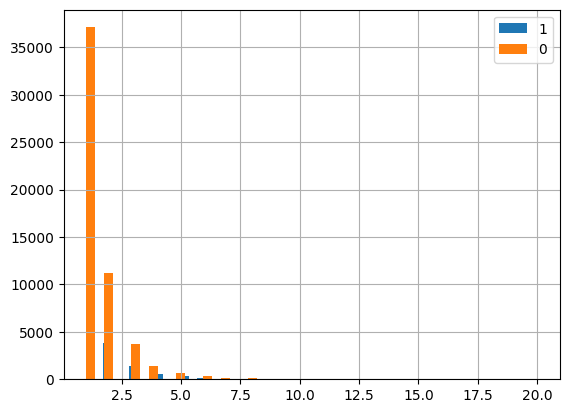

In [8]:
df[df['label'] == 1]['dif_start_end'].hist(bins=50, label='1')
df[df['label'] == 0]['dif_start_end'].hist(bins=50, label='0')
plt.legend()
plt.show()

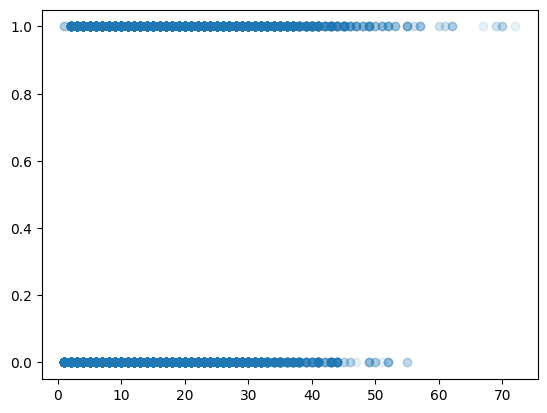

In [9]:
plt.scatter(df['word_count'],df['label'],alpha=0.1)
plt.show()

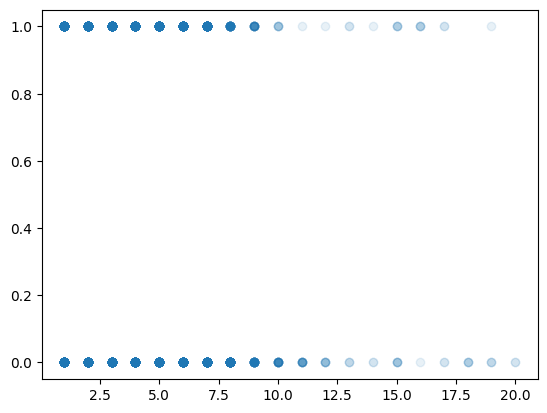

In [10]:
plt.scatter(df['dif_start_end'],df['label'],alpha=0.1)
plt.show()

In [11]:
X = df.drop(['text','dialogue_id', 'index_start', 'index_end', 'label'], axis=1)
y =df['label']

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [13]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Ajuster la forme des données
X_train = X_train.values.reshape(-1, len(X.columns))
X_test = X_test.values.reshape(-1, len(X.columns))

In [14]:
# Initialiser le modèle
model = DecisionTreeClassifier()

# Entraîner le modèle avec barre de progression
tqdm.write("Entraînement en cours...")
for _ in tqdm(range(10), desc="Epochs"):  # Remplacez '10' par le nombre d'époques souhaité
    model.fit(X_train, y_train)

# Prédictions avec barre de progression
tqdm.write("\nPrédictions en cours...")
y_pred = []
for _, row in tqdm(X_test, total=len(X_test), desc="Predictions"):
    y_pred.append(model.predict([row]))

y_pred = [item for sublist in y_pred for item in sublist]

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nRésultats du modèle :")
print("Accuracy: ", accuracy)
print("F1-score: ", f1)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

conf_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

print("\nMatrice de confusion :")
print(conf_df)


Entraînement en cours...


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

ValueError: could not convert string to float: 'PM'

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the base model (Decision Tree in this case)
base_model = DecisionTreeClassifier()

# Initialize the AdaBoost classifier with the base model
model = AdaBoostClassifier(base_model, n_estimators=50, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("F1-score: ", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

conf_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

print("Confusion Matrix:")
print(conf_df)

Accuracy:  0.7702330070315732
F1-score:  0.3521865889212828
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0        10267          739
Actual 1         2594          906


In [ ]:
# Initialize individual classifiers
decision_tree = DecisionTreeClassifier(random_state=42)
knn_classifier = KNeighborsClassifier()

# Create a voting classifier
voting_classifier = VotingClassifier(estimators=[
    ('decision_tree', decision_tree),
    ('knn', knn_classifier)
], voting='soft')  # 'soft' for probability-based voting

# Train the voting classifier
voting_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = voting_classifier.predict(X_test)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Ensemble Model (Voting Classifier) Results:")
print("Accuracy: ", accuracy)
print("F1-score: ", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

conf_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

print("\nConfusion Matrix:")
print(conf_df)

Ensemble Model (Voting Classifier) Results:
Accuracy:  0.764993795670757
F1-score:  0.4022444327546906

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         9950         1056
Actual 1         2353         1147


In [ ]:
# Model k-Nearest Neighbors (kNN)
knn_classifier = KNeighborsClassifier()

# Ajuster le modèle
knn_classifier.fit(X_train, y_train)

# Prédictions
y_pred = knn_classifier.predict(X_test)

# Évaluer le modèle kNN
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("k-Nearest Neighbors (kNN) Model Results:")
print("Accuracy: ", accuracy)
print("F1-score: ", f1)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

conf_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

print("\nConfusion Matrix:")
print(conf_df)

k-Nearest Neighbors (kNN) Model Results:
Accuracy:  0.7567902936715841
F1-score:  0.4285714285714286

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         9655         1351
Actual 1         2177         1323
